# House Price Prediction 
Using linear, ridge and lasso regression we explore the given data set to predict house prices.

The solution is divided into the following sections: 
- Data understanding and exploration
- Data preparation
- Model building
    - linear regression
    - ridge regression
    - lasso regression
- Evaluation
- Question (Part II)


## 1. Data Understanding and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [1]:
#all the imports. Trust me we are going to need these


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

from sklearn import linear_model, metrics
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# reading the dataset
houses = pd.read_csv("train.csv")


In [3]:
# summary of the dataset: 1460 rows, 81 columns, quite a few null values.
# We will deal with them in a moment
houses.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# we don't need the ID column as we already haven an index

houses = houses.drop('Id', axis=1)

# Let's have a quick look at the data itself
houses.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data Exploration

To perform linear regression, the (numeric) target variable should be linearly related to *at least one another numeric variable*. Let's see whether that's true in this case.

In [5]:
# all numeric (float and int) variables in the dataset
houses_numeric = houses.select_dtypes(include=['float64', 'int64'])
houses_numeric.head()


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


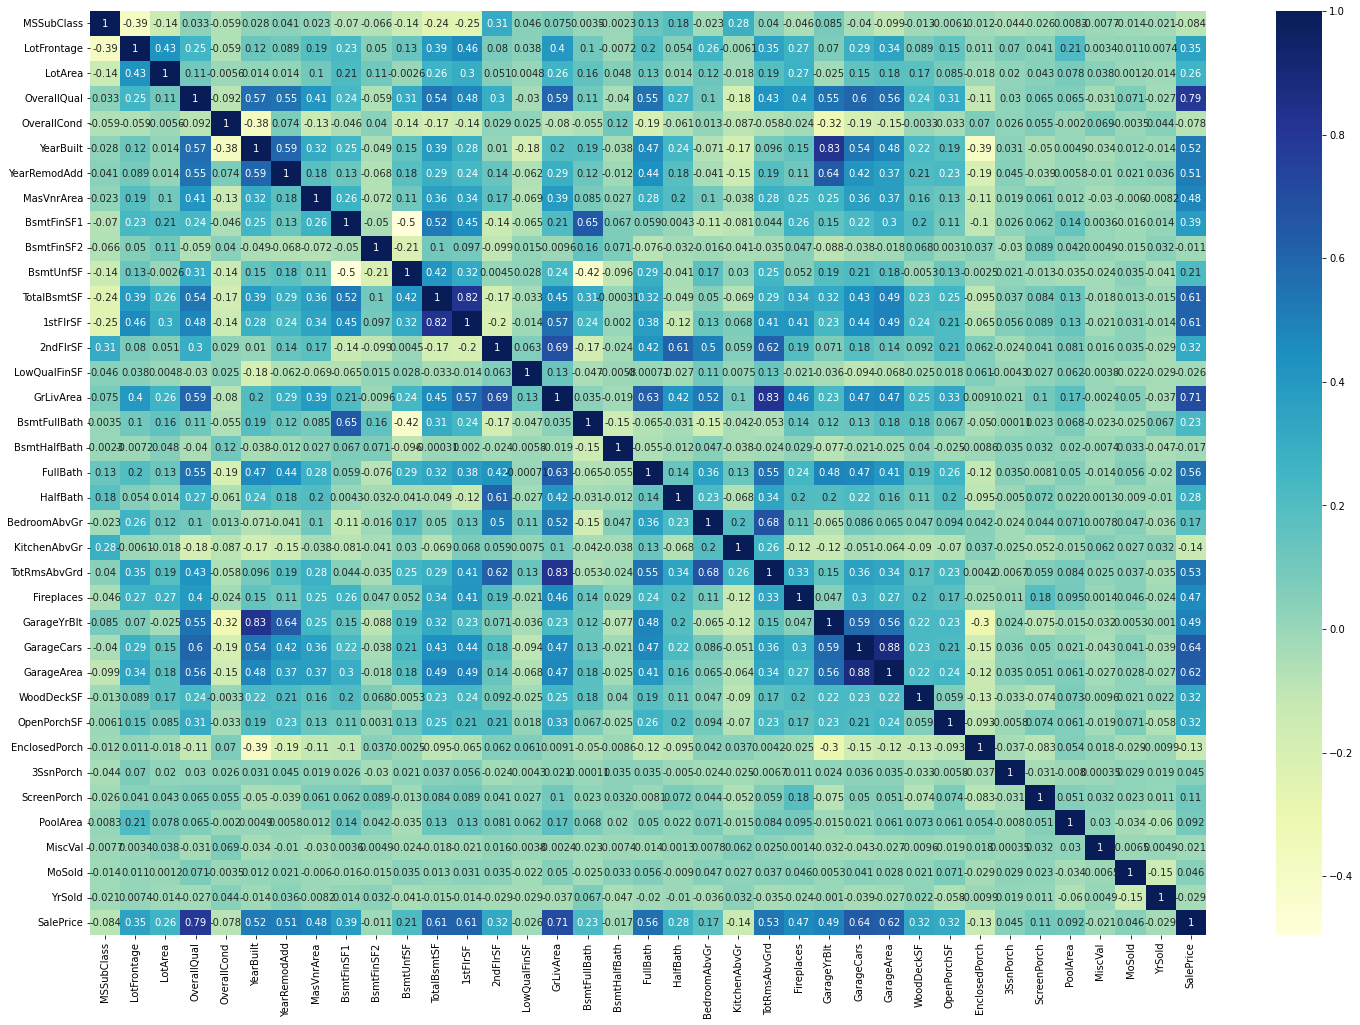

In [6]:
# To see if the variables are correletaed we can create a correlation matrix and plot it as a heatmap
cor = houses_numeric.corr()

# figure size
plt.figure(figsize=(25, 17))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()


In [7]:
# This heatmap is shows lots of correlations but it hard to make out if a single variable has no correlation with any other.
# We can remove all values in the correlation matrix that are close to zero and see if any of the variables loose all values.


cols = cor.columns

for col in cols:
    len = cor[col][(cor[col] >= 0.1) | (cor[col] <= -0.1)].size
    print(f'{col:15}{len:5}')


MSSubClass        10
LotFrontage       21
LotArea           19
OverallQual       26
OverallCond       11
YearBuilt         24
YearRemodAdd      23
MasVnrArea        25
BsmtFinSF1        23
BsmtFinSF2         5
BsmtUnfSF         22
TotalBsmtSF       26
1stFlrSF          27
2ndFlrSF          19
LowQualFinSF       5
GrLivArea         27
BsmtFullBath      20
BsmtHalfBath       3
FullBath          26
HalfBath          19
BedroomAbvGr      18
KitchenAbvGr      12
TotRmsAbvGrd      23
Fireplaces        24
GarageYrBlt       22
GarageCars        25
GarageArea        25
WoodDeckSF        20
OpenPorchSF       20
EnclosedPorch     12
3SsnPorch          1
ScreenPorch        4
PoolArea           6
MiscVal            1
MoSold             2
YrSold             2
SalePrice         27


In [8]:
# Looking at the list we can rest assured that every value has at least +/-0.1 correlation with at least one other value.
#



## 3. Data Preparation 


#### Data Preparation

Let's now prepare the data and build the model.

In [9]:
# we remember from looking at the data earlier that MSSubClass is a categorical values denoted in numbers
# we can replace the numeric values with the labels

MSSubClasses = {20: "1-STORY 1946 & NEWER ALL STYLES",
                30: "1-STORY 1945 & OLDER",
                40: "1-STORY W/FINISHED ATTIC ALL AGES",
                45: "1-1/2 STORY - UNFINISHED ALL AGES",
                50: "1-1/2 STORY FINISHED ALL AGES",
                60: "2-STORY 1946 & NEWER",
                70: "2-STORY 1945 & OLDER",
                75: "2-1/2 STORY ALL AGES",
                80: "SPLIT OR MULTI-LEVEL",
                85: "SPLIT FOYER",
                90: "DUPLEX - ALL STYLES AND AGES",
                120: "1-STORY PUD (Planned Unit Development) - 1946 & NEWER",
                150: "1-1/2 STORY PUD - ALL AGES",
                160: "2-STORY PUD - 1946 & NEWER",
                180: "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER",
                190: "2 FAMILY CONVERSION - ALL STYLES AND AGES"}

houses = houses.replace({'MSSubClass': MSSubClasses})
houses.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,2-STORY 1946 & NEWER,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,1-STORY 1946 & NEWER ALL STYLES,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,2-STORY 1946 & NEWER,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,2-STORY 1945 & OLDER,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,2-STORY 1946 & NEWER,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
# to create dummy variables let's first find the categorical values even those that are denoted in integers

# split into X and y
# we continue with all columns as predictors in X

X = houses.drop('SalePrice', 1)

y = houses['SalePrice']  # response variable in y

# categorical values
houses_categorical = X.select_dtypes(include=['object'])
houses_categorical.head()


,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,2-STORY 1946 & NEWER,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,1-STORY 1946 & NEWER ALL STYLES,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,2-STORY 1946 & NEWER,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,2-STORY 1945 & OLDER,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,2-STORY 1946 & NEWER,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [11]:
# convert into dummies - one hot encoding
houses_dummies = pd.get_dummies(houses_categorical, drop_first=True)
houses_dummies.head()


,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_2-STORY PUD - 1946 & NEWER,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [12]:
# drop categorical variables
X = X.drop(list(houses_categorical.columns), axis=1)

# concat dummy variables with X
X = pd.concat([X, houses_dummies], axis=1)


In [13]:
# The conversion to dummy variable also removes some of the null values.
# Lets see if we have any in the other columns

cols_with_nan = list(pd.isnull(X).sum()[pd.isnull(X).sum() > 0].index)
print(cols_with_nan)

# lets get the mean for every column with nan values to use as a replacement

cols_with_nan_mean = {}
for col in cols_with_nan:
    cols_with_nan_mean[col] = X[col].mean()

cols_with_nan_mean


['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


{'LotFrontage': 70.04995836802665,
 'MasVnrArea': 103.68526170798899,
 'GarageYrBlt': 1978.5061638868744}

In [14]:
# since the three columns with missing values are all numeric we can impute them easily

X.fillna(value=cols_with_nan_mean, inplace=True)


In [15]:
# scaling the features - necessary before using Ridge or Lasso


# storing column names in cols, since column names are (annoyingly) lost after
# scaling (the df is converted to a numpy array)
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns


Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=258)

In [16]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.7,
                                                    test_size=0.3, random_state=100)


## 3. Model Building

### Linear Regression

Let's now build a linear regression for reference.

In [17]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [18]:
# since we are going to look at the metrics for linear, ridge and lasso we can 
# define a function to show us the metrics and save them for later comparison

def collect_metrics(model, X_train, X_test, y_train, y_test):

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    metrics = []

    r2_train_lr = r2_score(y_train, y_pred_train)
    print(f'{"R2 Train:":<10}{r2_train_lr:>25}')
    metrics.append(r2_train_lr)

    r2_test_lr = r2_score(y_test, y_pred_test)
    print(f'{"R2 Test:":<10}{r2_test_lr:>25}')
    metrics.append(r2_test_lr)

    rss1_lr = np.sum(np.square(y_train - y_pred_train))
    print(f'{"RSS Train:":<10}{rss1_lr:>25}')
    metrics.append(rss1_lr)

    rss2_lr = np.sum(np.square(y_test - y_pred_test))
    print(f'{"RSS Test:":<10}{rss2_lr:>25}')
    metrics.append(rss2_lr)

    mse_train_lr = mean_squared_error(y_train, y_pred_train)
    print(f'{"MSE Train:":<9}{mse_train_lr:25}')
    metrics.append(mse_train_lr**0.5)

    mse_test_lr = mean_squared_error(y_test, y_pred_test)
    print(f'{"MSE Test:":<10}{mse_test_lr:25}')
    metrics.append(mse_test_lr**0.5)

    return metrics


In [19]:
metrics_lm = collect_metrics(lm, X_train, X_test, y_train, y_test)

R2 Train:        0.9504319103870064
R2 Test:     -5.177658125831313e+25
RSS Train:           316279049886.0
RSS Test:    1.4594329837150876e+38
MSE Train:       309773800.08423114
MSE Test:     3.332038775605223e+35


### Ridge Regression

In [20]:
# list of alphas (aka λ) to tune - if value too high it will lead to underfitting, if it is too low,
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 
                    0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,  4.0, 5.0,  6.0, 
                    7.0,  8.0,  9.0,  10.0,  20, 50,  100,  500,  1000]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator=ridge,
                        param_grid=params,
                        scoring='neg_mean_absolute_error',
                        cv=folds,
                        return_train_score=True,
                        verbose=1)
model_cv.fit(X_train, y_train)

# Saving the best hyperparameter alpha
best_alpha_ridge = model_cv.best_params_['alpha']
print(f"Best alpha: {best_alpha_ridge}")

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best alpha: 100


In [21]:
# since 100 is a rather high value for alpha and our parameter sweep only offers a much lower (half) and 
# a much higher value (5x) next to it, we should do a more precise sweep now that we have rough idea.
params = {'alpha': [50, 60, 70, 80, 90,  100, 110, 120, 130, 140, 150, 175, 200, 250, 300]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator=ridge,
                        param_grid=params,
                        scoring='neg_mean_absolute_error',
                        cv=folds,
                        return_train_score=True,
                        verbose=1)
model_cv.fit(X_train, y_train)

# Saving the best hyperparameter alpha
best_alpha_ridge = model_cv.best_params_['alpha']
print(f"Best alpha: {best_alpha_ridge}")


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best alpha: 120


In [22]:
# Fitting Ridge model for alpha and printing coefficients which have been penalised
alpha = model_cv.best_params_['alpha']
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)


Ridge(alpha=120)

In [23]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
metrics_ridge = collect_metrics(ridge, X_train, X_test, y_train, y_test)

R2 Train:        0.9358940025358362
R2 Test:          0.729257329251334
RSS Train:        409041061058.8695
RSS Test:         763145758539.7758
MSE Train:        400627875.6698036
MSE Test:        1742341914.4743738


### Lasso Regression

In [24]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 
                    0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,  4.0, 5.0,  6.0, 
                    7.0,  8.0,  9.0,  10.0,  20, 50,  100,  500,  1000]}

lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator=lasso,
                        param_grid=params,
                        scoring='neg_mean_absolute_error',
                        cv=folds,
                        return_train_score=True,
                        verbose=1)

model_cv.fit(X_train, y_train)

# Saving the best hyperparameter alpha
best_alpha_lasso = model_cv.best_params_['alpha']
print(f"Best alpha: {best_alpha_lasso}")

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best alpha: 500


In [25]:
# Here again the first param sweep gives us a rough value for alpha. We can search again to get a more precise value
params = {'alpha': [250, 300, 350, 400, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 600, 650, 700, 750]}

lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator=lasso,
                        param_grid=params,
                        scoring='neg_mean_absolute_error',
                        cv=folds,
                        return_train_score=True,
                        verbose=1)

model_cv.fit(X_train, y_train)

# Saving the best hyperparameter alpha
best_alpha_lasso = model_cv.best_params_['alpha']
print(f"Best alpha: {best_alpha_lasso}")


Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best alpha: 490


In [26]:
# This time we see only a small improvement in alpha (-1% vs. +20%)

alpha = model_cv.best_params_['alpha']

lasso = Lasso(alpha=alpha)

lasso.fit(X_train, y_train)


Lasso(alpha=490)

In [27]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

metrics_lasso = collect_metrics(lasso, X_train, X_test, y_train, y_test)

R2 Train:        0.9388504376397053
R2 Test:         0.5321447730025004
RSS Train:        390176939140.8804
RSS Test:         1318749390727.745
MSE Train:       382151752.34170455
MSE Test:         3010843357.825902


## Evaluation

In [28]:
# Creating a table which contain all the metrics

lm_table = {'Metric': ['R2 (Train)', 'R2 (Test)', 'RSS (Train)', 'RSS (Test)',
                       'MSE (Train)', 'MSE (Test)'],
            'Linear Regression': metrics_lm
            }

lm_metrics = pd.DataFrame(lm_table, columns=['Metric', 'Linear Regression'])

rg_metrics = pd.Series(metrics_ridge, name='Ridge Regression')
ls_metrics = pd.Series(metrics_lasso, name='Lasso Regression')

final_metrics = pd.concat([lm_metrics, rg_metrics, ls_metrics], axis=1)

# Let's change the settings here so we can easily see the (huge) differences.
pd.options.display.float_format = '{:.4f}'.format

#Drum role... 

final_metrics.round(decimals=4)

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 (Train),0.9504,0.9359,0.9389
1,R2 (Test),-51776581258313133751009280.0000,0.7293,0.5321
2,RSS (Train),316279049886.0000,409041061058.8695,390176939140.8804
3,RSS (Test),145943298371508764628226394257830707200.0000,763145758539.7758,1318749390727.7451
4,MSE (Train),17600.3920,20015.6907,19548.7021
5,MSE (Test),577238146314432640.0000,41741.3693,54871.1523


We can see that both Ridge and Lasso were able to handle out linear models overfitting problem.
Especially the off-the-charts R2 was brought down to much more reasonable 0.73 and 0.53.
We can see that ridge regression performed better.

In [29]:
betas = pd.DataFrame(index=X.columns)
betas.rows = X.columns

betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

pd.set_option('display.max_rows', None)
betas.head(50)

,Linear,Ridge,Lasso
LotFrontage,2045.5403,1523.6562,1729.1834
LotArea,7022.9878,4205.3777,3672.7417
OverallQual,8960.4123,10363.2673,11816.8245
OverallCond,6638.0821,4465.4347,5611.1799
YearBuilt,12909.2731,4132.1159,9164.5407
YearRemodAdd,2087.5074,3303.3651,3058.4640
MasVnrArea,4222.6495,4470.0975,3859.2527
BsmtFinSF1,53494554785435520.0000,5187.1519,6360.5968
BsmtFinSF2,18920716508996536.0000,1284.2855,0.0000
BsmtUnfSF,51825422036255184.0000,947.7056,-0.0000


# Answers

Answering the questions we were tasked to resolve we can now say that:

- __Ridge Regression__ is the best approach.

- The best value for lambda (aka alpha) is __120__


- We can expect the model to do reasonably well with an __R2 of 0.73__ but should not rely on it to be always correct in our business context.

- To the question which factors have great impact see the sorted list of absolute betas below.

In [30]:
factors_by_impact = betas['Ridge'].abs().sort_values(ascending=False)

# top 20 factors
factors_by_impact[:20]

PoolQC_Gd              19688.8035
GrLivArea              12598.6430
Condition2_PosN        11086.1901
OverallQual            10363.2673
2ndFlrSF                8663.7637
BsmtQual_Gd             7891.6980
1stFlrSF                7535.6194
KitchenQual_Gd          7201.7435
TotalBsmtSF             6819.5887
Neighborhood_NoRidge    6021.0588
RoofMatl_WdShngl        5819.3149
KitchenQual_TA          5577.0436
BsmtFinSF1              5187.1519
BsmtQual_TA             5127.1490
Neighborhood_NridgHt    5031.5534
BsmtExposure_Gd         4623.3616
MasVnrArea              4470.0975
OverallCond             4465.4347
ExterQual_TA            4391.4609
LotArea                 4205.3777
Name: Ridge, dtype: float64

# Subjective Questions

To answer the subjective questions in part II of the assignment we need to do some experiments. These will only be briefly commented as they are explained in the accompanying PDF.


### Question 1

In [31]:
# fit with double the best alpha
lasso = Lasso(alpha=best_alpha_lasso*2)

lasso.fit(X_train, y_train)

metrics_lasso2 = collect_metrics(lasso, X_train, X_test, y_train, y_test)

R2 Train:        0.9272751418322032
R2 Test:         0.5652055489444049
RSS Train:       464035415203.40094
RSS Test:        1225560567317.1948
MSE Train:       454491102.06013805
MSE Test:         2798083487.025559


In [32]:
# fit with double the best alpha
ridge = Ridge(alpha=best_alpha_ridge*2)

ridge.fit(X_train, y_train)

metrics_ridge2 = collect_metrics(ridge, X_train, X_test, y_train, y_test)

R2 Train:        0.9228237587235051
R2 Test:         0.7833805537051655
RSS Train:        492438350061.0836
RSS Test:         610587947588.7983
MSE Train:       482309843.35071856
MSE Test:        1394036410.0200875


In [33]:
# getting the same metrics
lm_metrics = pd.DataFrame(lm_table, columns=['Metric', 'Linear Regression'])

rg_metrics2 = pd.Series(metrics_ridge2, name='Ridge Regression (dbl a)')
ls_metrics2 = pd.Series(metrics_lasso2, name='Lasso Regression (dbl a)')

final_metrics = pd.concat([lm_metrics, rg_metrics, rg_metrics2, ls_metrics, ls_metrics2], axis=1)

# Let's change the settings here so we can easily see the (huge) differences.
pd.options.display.float_format = '{:.4f}'.format

#Drum role... 

final_metrics.round(decimals=4)

,Metric,Linear Regression,Ridge Regression,Ridge Regression (dbl a),Lasso Regression,Lasso Regression (dbl a)
0,R2 (Train),0.9504,0.9359,0.9228,0.9389,0.9273
1,R2 (Test),-51776581258313133751009280.0000,0.7293,0.7834,0.5321,0.5652
2,RSS (Train),316279049886.0000,409041061058.8695,492438350061.0836,390176939140.8804,464035415203.4009
3,RSS (Test),145943298371508764628226394257830707200.0000,763145758539.7758,610587947588.7983,1318749390727.7451,1225560567317.1948
4,MSE (Train),17600.3920,20015.6907,21961.5538,19548.7021,21318.7969
5,MSE (Test),577238146314432640.0000,41741.3693,37336.7970,54871.1523,52896.9138


In [34]:
betas_dbl_a = pd.DataFrame(index=X.columns)
betas_dbl_a.rows = X.columns

betas_dbl_a['Linear'] = lm.coef_
betas_dbl_a['Ridge'] = ridge.coef_
betas_dbl_a['Lasso'] = lasso.coef_

betas_dbl_a.head(50)

,Linear,Ridge,Lasso
LotFrontage,2045.5403,1411.0041,1671.4784
LotArea,7022.9878,3501.7765,3193.8666
OverallQual,8960.4123,9743.4560,14289.0425
OverallCond,6638.0821,3695.1307,4613.4593
YearBuilt,12909.2731,2818.3101,8583.1789
YearRemodAdd,2087.5074,3348.9248,3606.8004
MasVnrArea,4222.6495,4371.9484,3189.2520
BsmtFinSF1,53494554785435520.0000,4302.2519,6572.7738
BsmtFinSF2,18920716508996536.0000,1022.7131,0.0000
BsmtUnfSF,51825422036255184.0000,993.6365,-0.0000


In [35]:
# the most important factors
print(betas_dbl_a['Ridge'].abs().idxmax())
print(betas_dbl_a['Lasso'].abs().idxmax())

PoolQC_Gd
GrLivArea


### Question 3

In [36]:
# lets find the five most important factors for the lasso model

top_5 = list(betas['Lasso'].abs().sort_values(ascending=False)[:5].index)
top_5

['GrLivArea', 'PoolQC_Gd', 'Condition2_PosN', 'OverallQual', 'BsmtQual_Gd']

In [37]:
# drop the top 5 features
X_train_cut = X_train.drop(top_5, axis=1)
X_test_cut = X_test.drop(top_5, axis=1)

In [38]:
# fit lasso without the top 5
lasso = Lasso(alpha=best_alpha_lasso)

lasso.fit(X_train_cut, y_train)

# metrics for sanity check
metrics_lasso3 = collect_metrics(lasso, X_train_cut, X_test_cut, y_train, y_test)

R2 Train:        0.9020464629028122
R2 Test:         0.8750408103476888
RSS Train:        625012016560.5583
RSS Test:        352224033655.39154
MSE Train:        612156725.3286566
MSE Test:         804164460.4004374


In [39]:
# list the new top factors
betas_cut = pd.DataFrame(index=X_train_cut.columns)
betas_cut.rows = X_train_cut.columns

betas_cut['Lasso'] = lasso.coef_
betas_cut['Lasso'].abs().sort_values(ascending=False)[:10].index

Index(['RoofMatl_CompShg', '2ndFlrSF', '1stFlrSF', 'RoofMatl_WdShngl',
       'RoofMatl_Tar&Grv', 'KitchenQual_Gd', 'KitchenQual_TA',
       'RoofMatl_WdShake', 'Neighborhood_NridgHt', 'Neighborhood_NoRidge'],
      dtype='object')